# Project 3: Implementing a Simple Recurrent Neural Network (RNN)

## Introduction

In this project, you will design, implement, and evaluate a simple Recurrent Neural Network (RNN) from scratch. This will involve building the entire pipeline, from data preprocessing to model training and evaluation.

## Objectives

1. Set up TensorFlow or PyTorch environments. You are free to choose your preferred DL platform.
2. Use GPU for training.
3. Create a data loader and implement data preprocessing where needed.
4. Design a Convolutional Neural Network.
5. Train and evaluate your model. Make sure to clearly show loss and accuracy values. Include visualizations too.
6. Answer assessment questions.

## Dataset

You are free to choose any dataset for this project! Kaggle would be a good source to look for datasets. Below are some examples:
- Daily Minimum Temperatures in Melbourne: This dataset contains the daily minimum temperatures in Melbourne, Australia, from 1981 to 1990.
- Daily Bitcoin Prices: This dataset contains historical daily prices of Bitcoin, which can be used for time series forecasting projects.
- Text8 Dataset: This dataset consists of the first 100 million characters from Wikipedia. It's great for text generation or language modeling tasks.
- IMDB Movie Reviews: This dataset contains 50,000 movie reviews for sentiment analysis, split evenly into 25,000 training and 25,000 test sets.
- Jena Climate Dataset: This dataset records various weather attributes (temperature, pressure, humidity, etc.) every 10 minutes, making it ideal for time series analysis.
- Earthquake Aftershocks: This dataset contains seismic data, suitable for predicting aftershocks following major earthquakes.


In [56]:
# !pip install fluidsynth
# !pip install --upgrade pyfluidsynth
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf #only use its util to load data, because there are too much file to unload onto github (and/or even zip it just to add step on setting it up outside the code)

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [9]:
# set datapath, data source: https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )
    
midi_files = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(midi_files))

Number of files: 1282


## Preprocess (Extracting Note from midi files)

midi file is different format from typical audio(mp3,wav) it a record of pitch/velocity/duration of the note instead of actual sound recording

 prepare midi_to_note function, this is to extract midi file into note
which is contain 
- pitch - the key of the note range from 0-127 starting from C-1 (C in lowest octave)
from the example file
    - 55 is G3
    - 81 is A#5 (A sharp)
    - 62 is D4 etc
- start,end - when do note start and end in the sequence which use to calculate duration
- step - different between start of itself and start of the note before them (this is for knowning space between each note)


In [5]:
import random

def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append((end - start) * random.randint(2,4))
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

sample_file = 'example.midi'
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,43,0.000000,0.079545,0.000000,0.159091
1,31,0.009091,0.075000,0.009091,0.263636
2,44,0.111364,0.184091,0.102273,0.218182
3,32,0.113636,0.186364,0.002273,0.218182
4,46,0.175000,0.270455,0.061364,0.381818


## Visualize note sequence

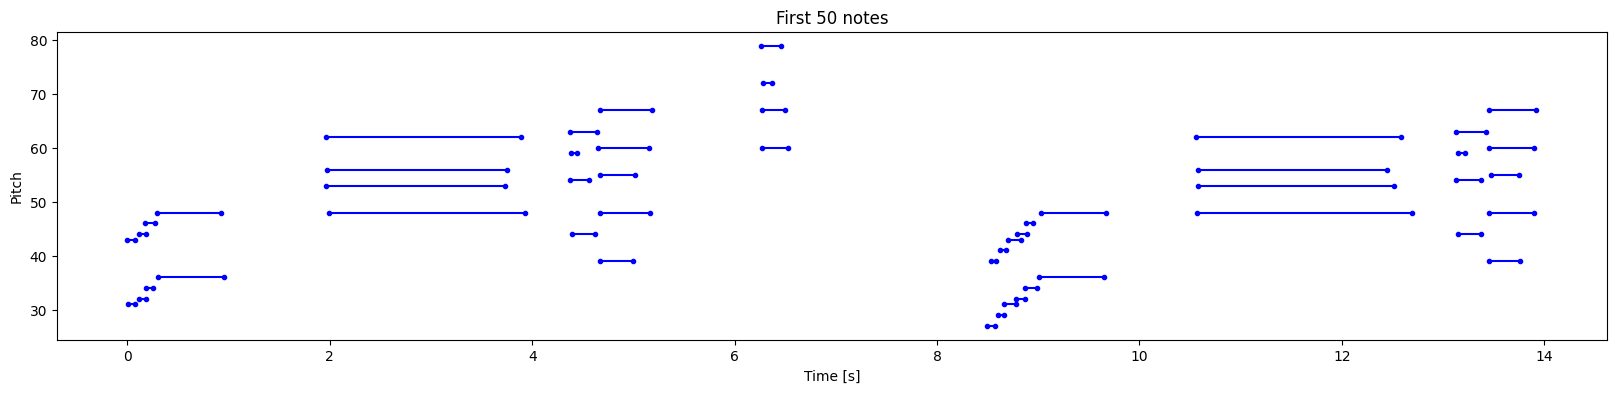

In [6]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

sample_file = 'example.midi'
raw_notes = midi_to_notes(sample_file)
#first 50 note
plot_piano_roll(raw_notes, count=50)   
#whole track
# plot_piano_roll(raw_notes)    

## Function for playing Midi file
midi file is different format from typical audio(mp3,wav) it a record of pitch/velocity/duration of the note instead of actual sound recording

In [7]:
import pygame
import time

def play_midi(file_path):
    pygame.mixer.init()
    pygame.mixer.music.load(file_path)
    pygame.mixer.music.play()
    
    # Wait a bit to ensure playback has started
    time.sleep(2)
    
    print("Press 'q' to quit")
    while pygame.mixer.music.get_busy():
        # Check for keyboard input to stop playback
        if input("Press 'q' to quit: ").lower() == 'q':
            pygame.mixer.music.stop()
            break

example_file = 'example.midi'
play_midi(example_file)

pygame 2.6.0 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html
Press 'q' to quit


Press 'q' to quit:  q


# Create training dataset

- randomly select midi file from "midi_files"(data from 1st step) and extract note dataframe and concat them together
- then format them into 2D array by key order
- ```
  array([[pitch1 , step1,  duration1 ],
         [pitch2 , step2,  duration2 ],
         [pitch3 , step3,  duration3 ]]...)

- and convert to pytorch tensor
- seq_length is to set how many note to feed to model at a time, (collate_fn is for combining samples into batch)

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import random

num_files = 5
all_notes = []
selected_files = random.sample(midi_files, num_files)
for f in selected_files:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)


n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key].values for key in key_order], axis=1)

# Convert to PyTorch tensors
train_notes = torch.tensor(train_notes, dtype=torch.float32)

class NotesDataset(Dataset):
    def __init__(self, notes, seq_length):
        self.notes = notes
        self.seq_length = seq_length
    
    def __len__(self):
        return len(self.notes) - self.seq_length
    
    def __getitem__(self, idx):
        idx = idx.item() if torch.is_tensor(idx) else idx
        return {
            'sequence': self.notes[idx:idx+self.seq_length],
            'target': self.notes[idx+self.seq_length]
        }

def collate_fn(batch):
    sequences = [item['sequence'] for item in batch]
    targets = [item['target'] for item in batch]
    return {
        'sequences': torch.stack(sequences),
        'targets': torch.stack(targets)
    }

seq_length = 50
notes_ds = NotesDataset(train_notes, seq_length)
train_loader = DataLoader(notes_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)

# Example usage
for batch in train_loader:
    seq_batch, target_batch = batch['sequences'], batch['targets']
    print('Sequence batch shape:', seq_batch.shape)
    print('Target batch shape:', target_batch.shape)
    break  # Stop after the first batch for demonstration


Number of notes parsed: 22516
Sequence batch shape: torch.Size([64, 50, 3])
Target batch shape: torch.Size([64, 3])


## Check Training Data Charateristic
```
this was added later during fine tuning the model to generate accepatable output sound
use to check distributionfor each value (pitch, step, duration)
in data loader, I use "notes['duration'].append((end - start) * random.randint(2,4))", randomly multiplying duration by 2-4
without it, with majority of data having low step and low duration making the early model/attempt very unpleasant (medley of note)

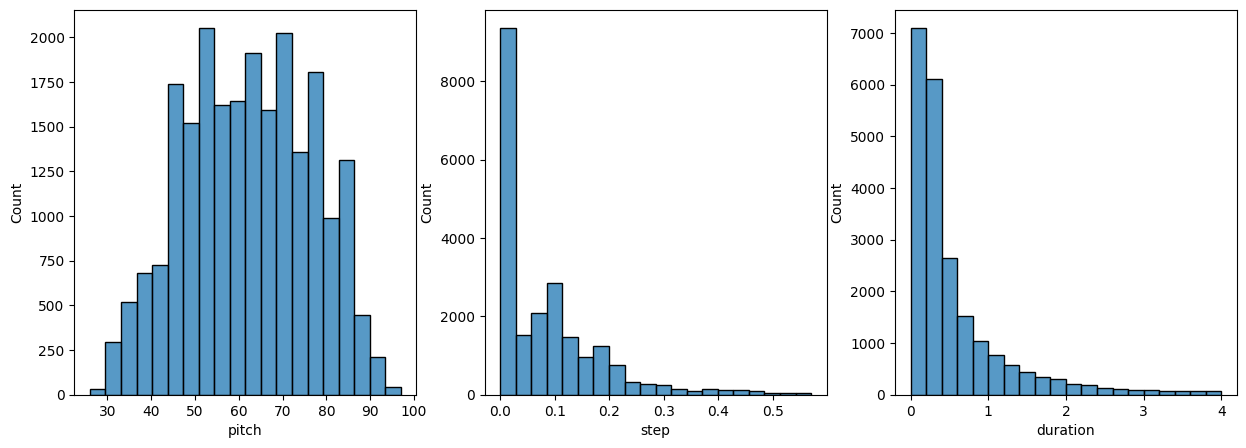

In [11]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

plot_distributions(all_notes)

# Model
```
LSTM-based model follow by 3 linears layer to predict note's value (pitch,step,duration)
using custom lost function, this is for step and duration that can't be negative (negative step/duration would cause error to midi file that end's of the note is before the start of the note)
and using mean squared error to keep the prediction (note generate) stay relatively the same with training data (ie maintain the pattern that would be common in music and hence model could generate something good)
while pitch still use CrossEntropyLoss because it a classification (note from 0 to 127)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define custom loss function for step and duration
def mse_with_positive_pressure(y_true, y_pred):
    mse = torch.mean((y_true - y_pred) ** 2)
    positive_pressure = 10 * torch.clamp(-y_pred, min=0.0)
    return mse + positive_pressure

input_size = 3
hidden_size = 128
learning_rate = 0.005

# Define the model architecture
class MusicModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MusicModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.pitch = nn.Linear(hidden_size, 128)
        self.step = nn.Linear(hidden_size, 1)
        self.duration = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        pitch_out = self.pitch(lstm_out[:, -1, :])
        step_out = self.step(lstm_out[:, -1, :])
        duration_out = self.duration(lstm_out[:, -1, :])
        return {
            'pitch': pitch_out,
            'step': step_out,
            'duration': duration_out
        }

model = MusicModel(input_size, hidden_size).cuda()  # Move model to GPU

#check that model on gpu
for param in model.parameters():
    print(param.device)
    break

cuda:0


# Training model
```
because this scenario doesn't have an actual ground truth that the note generated is good or not (it subjective that music is good or bad)
but Step MSE do show that most predicted step (gap between note) is really close to trained data
for Duration MSE that note predicted have some variant base on both modification for duration during data loader to avoid repetitive/undesire output
while Pitch Accuracy is extremely low due scenario
(for more format data like stock/market prices, it would be able to comparing it with ground truth directly)

and for epoch_loss that sum up from each lose function (*0.05 adjustment for pitch's CrossEntropy) and average with number of batches

In [16]:
#for tracking graident
def calculate_gradient_norm(model):
    total_norm = 0.0
    count = 0
    for param in model.parameters():
        if param.grad is not None:
            param_norm = param.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
            count += 1
    total_norm = (total_norm / count) ** (1. / 2) if count > 0 else 0.0
    return total_norm

Epoch [1/50], Loss: 1.2125, Pitch Accuracy: 0.0452, Step MAE: 0.1053, Duration MAE: 0.4643
Epoch [2/50], Loss: 1.2145, Pitch Accuracy: 0.0465, Step MAE: 0.1057, Duration MAE: 0.4643
Epoch [3/50], Loss: 1.2072, Pitch Accuracy: 0.0479, Step MAE: 0.1054, Duration MAE: 0.4623
Epoch [4/50], Loss: 1.2075, Pitch Accuracy: 0.0474, Step MAE: 0.1034, Duration MAE: 0.4611
Epoch [5/50], Loss: 1.2161, Pitch Accuracy: 0.0445, Step MAE: 0.1058, Duration MAE: 0.4658
Epoch [6/50], Loss: 1.1927, Pitch Accuracy: 0.0511, Step MAE: 0.1043, Duration MAE: 0.4572
Epoch [7/50], Loss: 1.1939, Pitch Accuracy: 0.0466, Step MAE: 0.1044, Duration MAE: 0.4606
Epoch [8/50], Loss: 1.2196, Pitch Accuracy: 0.0481, Step MAE: 0.1067, Duration MAE: 0.4597
Epoch [9/50], Loss: 1.2075, Pitch Accuracy: 0.0492, Step MAE: 0.1065, Duration MAE: 0.4581
Epoch [10/50], Loss: 1.2077, Pitch Accuracy: 0.0486, Step MAE: 0.1081, Duration MAE: 0.4598
Epoch [11/50], Loss: 1.1778, Pitch Accuracy: 0.0481, Step MAE: 0.1058, Duration MAE: 0.45

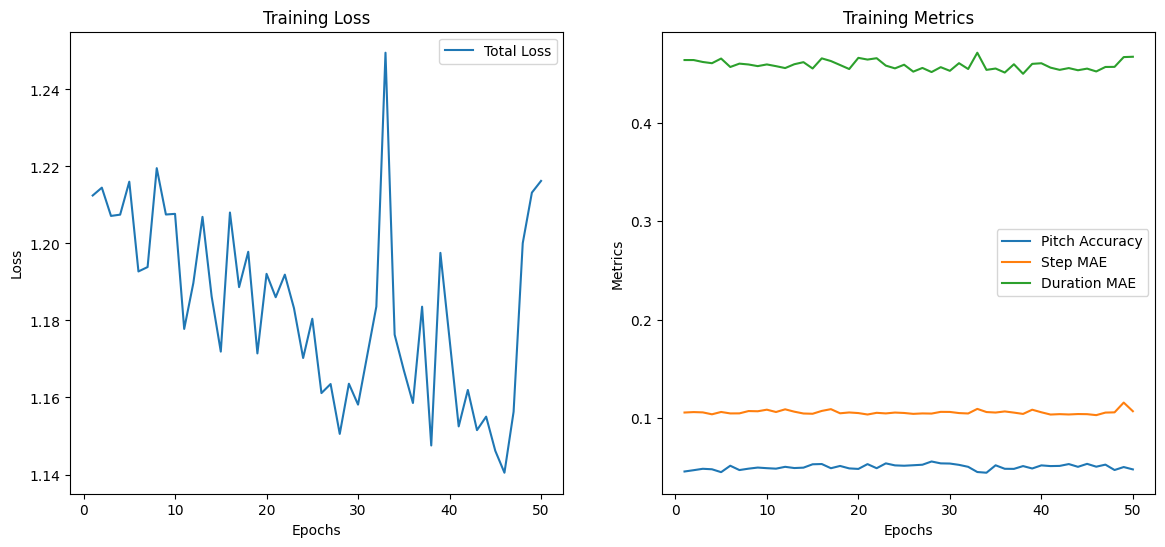

In [20]:
# Import MAE loss function
from torch.nn.functional import l1_loss
#Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = {
    'pitch': nn.CrossEntropyLoss(),
    'step': mse_with_positive_pressure,
    'duration': mse_with_positive_pressure
}
# Initialize history dictionary
history = {'loss': [], 'pitch_accuracy': [], 'step_mae': [], 'duration_mae': [], 'grad_norm': []}

epochs = 50
# Training loop with pitch accuracy and MAE for step and duration
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    correct_pitches = 0
    total_pitches = 0
    total_step_mae = 0.0
    total_duration_mae = 0.0
    total_grad_norm = 0.0
    
    for batch in train_loader:
        sequences, targets = batch['sequences'].cuda(), batch['targets'].cuda()
        
        optimizer.zero_grad()
        outputs = model(sequences)
        
        pitch_predictions = outputs['pitch'].argmax(dim=1)
        correct_pitches += (pitch_predictions == targets[:, 0].long()).sum().item()
        total_pitches += targets.size(0)
        
        step_mae = l1_loss(outputs['step'].squeeze(), targets[:, 1], reduction='sum').item()
        duration_mae = l1_loss(outputs['duration'].squeeze(), targets[:, 2], reduction='sum').item()
        
        total_step_mae += step_mae
        total_duration_mae += duration_mae
        
        losses = {
            'pitch': loss_fn['pitch'](outputs['pitch'], targets[:, 0].long()),
            'step': loss_fn['step'](outputs['step'].squeeze(), targets[:, 1]),
            'duration': loss_fn['duration'](outputs['duration'].squeeze(), targets[:, 2])
        }
        
        total_loss = 0.05 * losses['pitch'] + losses['step'] + losses['duration']
        total_loss = torch.mean(total_loss)  # Calculate mean over the batch
        
        # Backward pass and gradient calculation
        total_loss.backward()
        optimizer.step()
        
        # Track gradient norms
        total_grad_norm += calculate_gradient_norm(model)
        
        epoch_loss += total_loss.item()
    
    epoch_loss /= len(train_loader)
    pitch_accuracy = correct_pitches / total_pitches
    step_mae_avg = total_step_mae / total_pitches
    duration_mae_avg = total_duration_mae / total_pitches
    
    history['loss'].append(epoch_loss)
    history['pitch_accuracy'].append(pitch_accuracy)
    history['step_mae'].append(step_mae_avg)
    history['duration_mae'].append(duration_mae_avg)
    history['grad_norm'].append(total_grad_norm)
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Pitch Accuracy: {pitch_accuracy:.4f}, Step MAE: {step_mae_avg:.4f}, Duration MAE: {duration_mae_avg:.4f}')

# Plotting the training loss and metrics
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), history['loss'], label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), history['pitch_accuracy'], label='Pitch Accuracy')
plt.plot(range(1, epochs+1), history['step_mae'], label='Step MAE')
plt.plot(range(1, epochs+1), history['duration_mae'], label='Duration MAE')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training Metrics')
plt.legend()

plt.show()

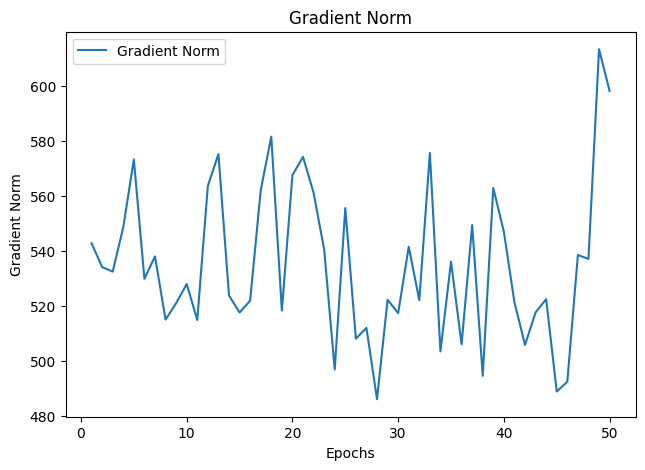

In [27]:
# print(history['grad_norm'])
plt.figure(figsize=(25, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), history['grad_norm'], label='Gradient Norm')
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm')
plt.legend()

## Prediction Function
```
this predict the next note from input data, using temperature to control randoness of the output to return 3 values the same way midi file needed (pitch,step,duration)
it will use initial input pattern to predict next note
temperature > 1.0, the model would return more random data due to it allowing range for softmax function
while temperature < 1.0, will restrict the output to be relatively similar to training data set pattern

In [32]:
import torch
import numpy as np
import pandas as pd

def predict_next_note(
    notes: np.ndarray, 
    model: torch.nn.Module, 
    temperature: float = 1.0) -> tuple[int, float, float]:
    """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""
    
    assert temperature > 0
    
    # Convert input to PyTorch tensor and add batch dimension
    inputs = torch.tensor(notes, dtype=torch.float32).unsqueeze(0).cuda()
    
    with torch.no_grad():
        predictions = model(inputs)
    
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']
    
    # Apply temperature for sampling
    pitch_logits /= temperature
    
    # Sample pitch using categorical distribution
    pitch_probs = torch.softmax(pitch_logits, dim=-1)
    pitch_idx = torch.multinomial(pitch_probs, num_samples=1).squeeze().item()
    
    # Sample step and duration
    step = torch.clamp(step, min=0.0).squeeze().item()
    duration = torch.clamp(duration, min=0.0).squeeze().item()
    
    return pitch_idx, step, duration

## Usage
```
this using the training data "all_notes" that created earlier, and randomly pick start index and pick the same amount 'seq_length' that used to feed the model early

     pitch      step  duration      start        end
0       36  0.466429  0.000000   0.466429   0.466429
1       89  0.303311  0.000000   0.769739   0.769739
2       71  0.181402  0.497776   0.951141   1.448917
3       29  0.184321  0.568430   1.135462   1.703891
4       66  0.206274  0.884625   1.341736   2.226362
..     ...       ...       ...        ...        ...
295     61  0.320479  3.065926  92.653393  95.719319
296     46  0.297490  2.743239  92.950882  95.694122
297     73  0.382729  2.729390  93.333611  96.063001
298     67  0.326338  3.084993  93.659949  96.744942
299     35  0.300618  2.753241  93.960568  96.713809

[300 rows x 5 columns]


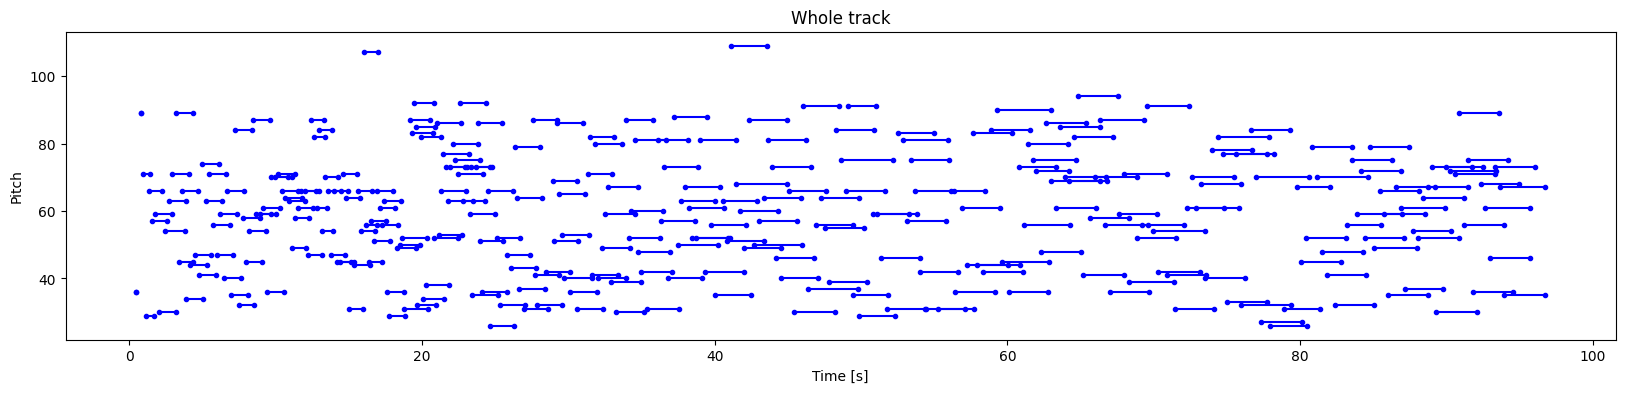

In [46]:
vocab_size = 128
temperature = 3.0
num_predictions = 300

key_order = ['pitch', 'step', 'duration']

sample_notes = np.stack([all_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
seq_length = 80 

input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0

for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes_df = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

print(generated_notes_df)
plot_piano_roll(generated_notes_df)

## now convert Dataframe back to Midi format and play

In [48]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 70,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [55]:
instrument_name = 'Acoustic Grand Piano'

out_file = 'output1.mid'
out_pm = notes_to_midi(
    generated_notes_df, out_file=out_file, instrument_name=instrument_name)

play_midi(out_file)

Press 'q' to quit


Press 'q' to quit:  q


      pitch      step  duration       start         end
0        36  0.466429  0.000000    0.466429    0.466429
1        89  0.303311  0.000000    0.769739    0.769739
2        71  0.181402  0.497776    0.951141    1.448917
3        29  0.184321  0.568430    1.135462    1.703891
4        66  0.206274  0.884625    1.341736    2.226362
...     ...       ...       ...         ...         ...
2095     71  0.353974  3.302173  594.621949  597.924122
2096     42  0.312234  2.769076  594.934183  597.703259
2097     35  0.461943  2.673535  595.396126  598.069661
2098     33  0.739203  2.552918  596.135328  598.688246
2099     45  0.807631  2.470879  596.942959  599.413838

[2100 rows x 5 columns]


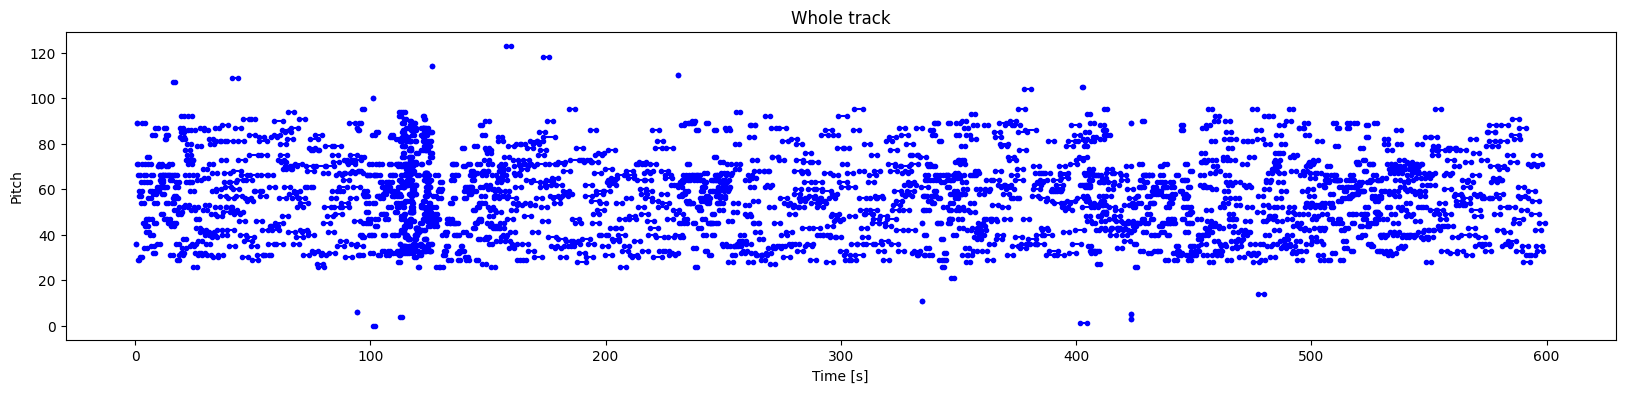

In [57]:
# this one is changing from training data as leading sequence to unseen data 

midi_file = 'a-jazz-piano-11041.midi'
raw_notes = midi_to_notes(midi_file)

seq_length = 100 

sample_notes = raw_notes.iloc[:seq_length]

# Extract pitch, step, and duration columns
key_order = ['pitch', 'step', 'duration']
input_notes = np.stack([sample_notes[key].values for key in key_order], axis=1)

# Normalize pitch (if needed) similar to training sequences
vocab_size = 128  # Assuming 128 possible pitches
input_notes[:, 0] /= vocab_size

for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

# Creating a DataFrame for generated notes
generated_notes_df = pd.DataFrame(
    generated_notes, columns=[*key_order, 'start', 'end'])

print(generated_notes_df)

plot_piano_roll(generated_notes_df)

In [58]:
instrument_name = 'Acoustic Grand Piano'

out_file = 'output2.mid'
out_pm = notes_to_midi(
    generated_notes_df, out_file=out_file, instrument_name=instrument_name)

play_midi(out_file)

Press 'q' to quit


Press 'q' to quit:  q


---
### Questions
Answer the following questions in detail.

1. What is a Recurrent Neural Network (RNN)? Describe its key components and how they differ from those in a feedforward neural network.
2. Explain the purpose of the recurrent connection in an RNN. How does it enable the network to handle sequential data?
3. What are vanishing and exploding gradients, and how do they affect the training of RNNs?
4. Describe the Long Short-Term Memory (LSTM) network and its key components. How does it address the issues of vanishing and exploding gradients?
5. What is the purpose of the GRU (Gated Recurrent Unit) in RNNs? Compare it with LSTM.
6. Explain the role of the hidden state in an RNN. How is it updated during the training process?
7. What are some common evaluation metrics used to assess the performance of an RNN on a sequential task, such as language modeling or time series forecasting?
8. How does data preprocessing impact the performance of RNNs? Provide examples of preprocessing steps for text and time series data.
9. What is sequence-to-sequence learning in the context of RNNs, and what are its applications?
10. How can RNNs be used for anomaly detection in time series data? Describe the general approach.


## Answer

1. ```
   RNN is neural network that designed to work with data sequence and predict the outcome from them instead of consider only the input
   when feedforward process each training/prediction give output then for next prediction, previous data doesn't affect the outcome
   while RNN's hidden state store data(pattern/information of the sequence) and its recurrent connection to form relationship between output
   - RNN also able to process and output various length of data sequence, unlike fixed-size input-output in feedforward model
   

2. ```
   recurrent connection is to enable the model to store value from previous inputs (in hidden state). which serve as context from earlier data of the sequence to predicting/generating next data. (in this case knowing what previous note is, and learn pattern from data of which note could follow it)
   because of this it able to accept various lengths and adjust with each input, and learn pattern between them

3. ```
   gradient is summary of how much loss function affect model (aka weight change)
   high gradient mean small change to weight would highly affect the loss value
   meanwhile low gradient mean need major change to weight to affect loss value
   and since loss value is for adjusting model toward convergence point
   vanishing gradient is when gradient is near 0, which mean the model can't learn (or learn very slowly) because it require significant change to the weight
   and for exploding gradient is when gradient value grow exponentially and mess up loss value just from slight change of weight
   
4. ```
   - Cell State: Linear flow of information that runs through the entire sequence, allowing LSTM to maintain long-term memory.
   - Forget Gate: Decides what information to throw away from the cell state.
   - Input Gate: update to the cell state.
   - Output Gate: Decides the output based on the cell state.
   ```
   and for vanishing/exploding gradient, Cell State that keep maintaining the data help preventing vanishing problem

   while for exploding gradient, mainly the Forget Gate that controls how much of the previous Cell State should be retained or forgottenselectively forgetting irrelevant information, prevents them from growing uncontrollably

5. ```
   GRU (Gated Recurrent Unit) is simplified version of LSTM instead of having 4 component like LSTM
   it merge Forget Gate and Input Gate together as single Update Gate, for faster speed (ie less computational requirement)
   but still serve the same purpose as LSTM to prevent vanishing gradient problem but may lack behind LSTM for longer and/or complex model
  
6. ```
   it stores information about the sequence history processed so far, representing the pattern of data
   which will be update during forward pass (base on current input and previous hidden state)
   and during Backpropagation
   example let say that
    1st hidden = 1
    2nd hidden = 1.2
    3rd hidden = 1.4
   for the 4th hidden, the model will process it from input and 3rd hidden
   and when this epoch ended, the gradient will affect all hidden state and then in next epoch, 1st hidden will be process from existed 1st hidden value and new input
   then 2nd hidden of 2nd epoch is 2nd new input with 1st hidden (the reason 1st hidden use itself only because it the 1st one in the sequence and there is no 0th hidden to refer to)
   so on and so forth
7. ```
   Perplexity: Measures how well the model predicts the sequence.(this model can't utilize this one, stock price/market/weather prediction would be more suitable)
   Accuracy: Measures the proportion of correct predictions in classification tasks within the sequence. (some what plausible for this one if want to restrict pitch tone to be in center, because generated one with lower tone would make it like horror sound for some reason)
   Mean Squared Error (MSE): Evaluates the difference between predicted and actual values in regression tasks (useful in this one to control Step and Duration pattern to be consistent)
   F1 Score: Harmonic mean of precision and recall, often used in sequence labeling tasks. (same case with preplexity)
8. ```
   Normalization: Scales numerical data to a common range (midi file already has note pitch in number, so divided by 128 all posible pitch did the job)
   Embedding: Converts categorical or textual data into dense numerical vectors (the step that convert midi file into [pitch,step,duration])
   Padding: making sure that data has uniform length by adding zeros or removing excess data (ie for weather casting if certain data is missing [rain volume,wind,temperature])
   Tokenization: more related to Natural Language Process, the split text into token (each word) and represent it as number using label encoder
9. ```
   This model is sample of it, sequence to sequence is taking set of data and generate new set of data, other application is chat bot, that recieve prompt (sentence, sequence of word that model will process and return the answer)
   
10. ```
    train the model with normal data sequence so it learn the pattern and add detection function that compare the predict value with the model
    and when the treshold/different between it more than certain value that can spot the anomally of the data
    


---
### Submission
Submit a link to your completed Jupyter Notebook (e.g., on GitHub (private) or Google Colab) with all the cells executed, and answers to the assessment questions included at the end of the notebook.